In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]

In [140]:
df = pd.read_csv('./strains_with_id.csv')
df.head(20)

,name,description,parents,Aroused,Creative,Energetic,Euphoric,Focused,Giggly,Happy,...,Spasticity,Paranoid,Anxious,Dry Eyes,Dry Mouth,Headache,Stress,avg rating,num ratings,id
0,Sweet Nina,Sweet Nina by Colorado Seed Inc. is a hybrid c...,"indica:hindu-kush,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.00,100.00,5.56,0.00,0.00,0.0,3.857143,6.0,hybrid:sweet-nina
1,Hawaiian Purple Kush,Hawaiian Purple Kush is an 80/20 indica-domina...,"sativa:hawaiian,indica:purple-kush,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,92.86,2.38,97.62,100.00,0.00,0.0,4.486486,32.0,indica:hawaiian-purple-kush
2,Lime Purple Mist,Lime Purple Mist is an indica-dominant strain ...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,100.00,0.00,0.0,4.333333,4.0,indica:lime-purple-mist
3,F'n louZER,F’n louZER is another potent genetic cross fro...,"indica:bloos-kloos,indica:white-rhino,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,100.00,0.00,100.00,100.00,100.00,0.0,NaN,NaN,indica:fn-louzer
4,Goldwing,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,50.00,0.00,50.00,100.00,50.00,0.0,4.666667,2.0,sativa:goldwing
5,Arabian Gold,Arabian Gold is a heavy sativa strain of myste...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,12.50,0.00,62.50,100.00,0.00,0.0,4.100000,7.0,sativa:arabian-gold
6,Madagascar,"Madagascar is an indica with a clean, floral s...",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,100.00,80.00,0.00,0.0,4.100000,7.0,indica:madagascar
7,Murkle,Murkle by OBSoul is the accidental genetic pai...,"indica:m-39,indica:purple-urkle,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,80.00,0.00,80.00,100.00,0.00,0.0,3.500000,2.0,indica:murkle
8,Berkeley,Berkeley is rumored to be the super-potent bot...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,66.67,100.00,83.33,66.67,50.00,0.0,4.315789,19.0,sativa:berkeley
9,Alf,The indica-dominant hybrid Alf was created by ...,"hybrid:animal-cookies,hybrid:cherry-pie,hybrid...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.00,0.00,100.00,0.00,0.0,5.000000,1.0,hybrid:alf


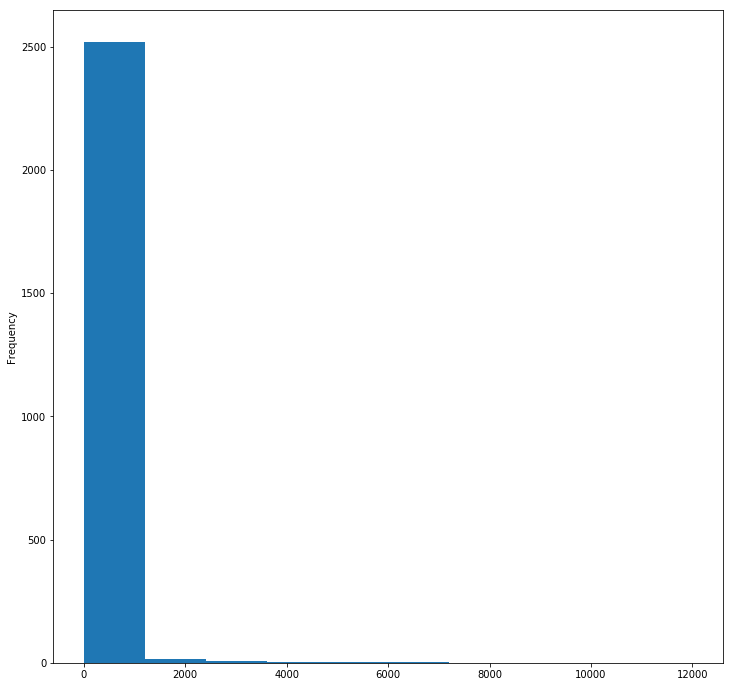

In [141]:
df['num ratings'].plot.hist(bins=10)

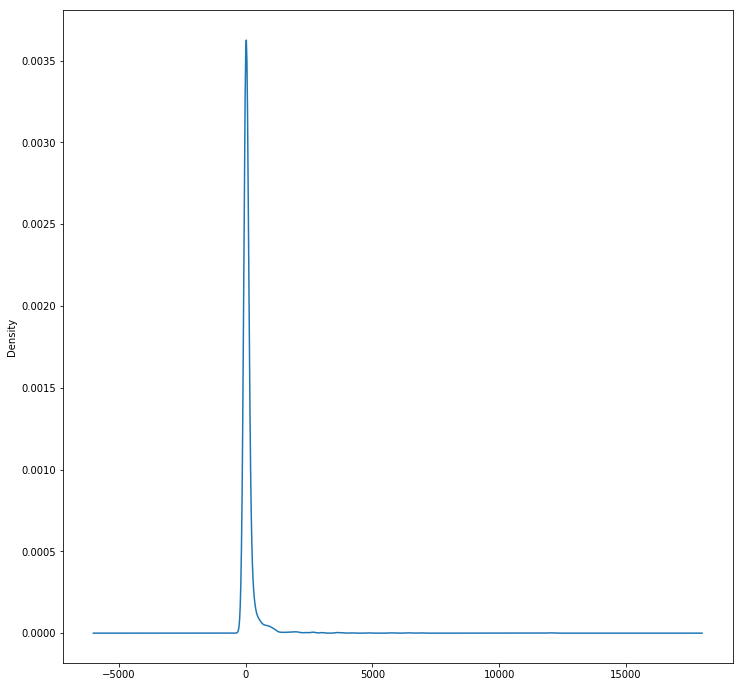

In [142]:
df['num ratings'].plot.density()

In [143]:
df.shape

(2669, 85)

In [144]:
parents=df['parents'].str.split(',',expand=True).head()
parents

,0,1,2,3,4,5,6,7
0,indica:hindu-kush,,None,None,None,None,None,None
1,sativa:hawaiian,indica:purple-kush,,None,None,None,None,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,indica:bloos-kloos,indica:white-rhino,,None,None,None,None,None
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
parents[7].unique()

array([None, nan], dtype=object)

In [156]:
df0=df.copy()#.drop(['parents'],axis=1)
split_parents=df['parents'].str.split(',',expand=True)
split_parents=split_parents.drop([7],axis=1)
split_parents=split_parents.fillna(value=np.nan)
split_parents=split_parents.replace('',np.nan)
split_parents=split_parents.rename(columns={0:'p0',1:'p1',2:'p2',3:'p3',4:'p4',5:'p5',6:'p6'})
split_parents.head()

,p0,p1,p2,p3,p4,p5,p6
0,indica:hindu-kush,NaN,NaN,NaN,NaN,NaN,NaN
1,sativa:hawaiian,indica:purple-kush,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,indica:bloos-kloos,indica:white-rhino,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [157]:
# TODO Really need to get the flavor thing fixed.
split_parents['p2'].value_counts().head(20)

hybrid:skunk-1               17
indica:afghani               10
Sweet                         9
indica:northern-lights        5
hybrid:white-widow            5
sativa:thai                   5
sativa:hawaiian               5
indica:blueberry              5
hybrid:og-kush                4
hybrid:blackberry             4
Woody                         4
hybrid:cinderella-99          4
indica:northern-lights--5     3
indica:hash-plant             3
sativa:haze                   3
indica:purple-urkle           3
indica:bubba-kush             3
Berry                         3
indica:master-kush            3
hybrid:nyc-diesel             3
Name: p2, dtype: int64

In [158]:
df1=df0.join(split_parents)
df1.head()

,name,description,parents,Aroused,Creative,Energetic,Euphoric,Focused,Giggly,Happy,...,avg rating,num ratings,id,p0,p1,p2,p3,p4,p5,p6
0,Sweet Nina,Sweet Nina by Colorado Seed Inc. is a hybrid c...,"indica:hindu-kush,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.857143,6.0,hybrid:sweet-nina,indica:hindu-kush,NaN,NaN,NaN,NaN,NaN,NaN
1,Hawaiian Purple Kush,Hawaiian Purple Kush is an 80/20 indica-domina...,"sativa:hawaiian,indica:purple-kush,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.486486,32.0,indica:hawaiian-purple-kush,sativa:hawaiian,indica:purple-kush,NaN,NaN,NaN,NaN,NaN
2,Lime Purple Mist,Lime Purple Mist is an indica-dominant strain ...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.333333,4.0,indica:lime-purple-mist,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,F'n louZER,F’n louZER is another potent genetic cross fro...,"indica:bloos-kloos,indica:white-rhino,",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,indica:fn-louzer,indica:bloos-kloos,indica:white-rhino,NaN,NaN,NaN,NaN,NaN
4,Goldwing,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.666667,2.0,sativa:goldwing,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [159]:
df1.shape

(2669, 92)

In [160]:
df1=df1.dropna(subset=['num ratings'])
df1.shape

(2553, 92)

In [166]:
df2=df1[df1['num ratings'] > 100.0]
df2.shape

(454, 92)

In [167]:
df2.to_csv('./strains_reduced.csv',index=False)

In [168]:
# TODO merge in that file at some point
%run ./reformat.py

Strain hybrid:alien-walker is missing parent hybrid:albert-walker
Strain hybrid:alien-walker is missing parent hybrid:tahoe-alien
Strain hybrid:alien-walker has no parents or children, discarding record
Strain sativa:kilimanjaro is missing parent sativa:african
Strain sativa:kilimanjaro has no parents or children, discarding record
Strain indica:pitbull is missing parent hybrid:p-91
Strain indica:pitbull is missing parent sativa:sugar-plum
Strain indica:pitbull has no parents or children, discarding record
Strain indica:redwood-kush has no parents or children, discarding record
Strain hybrid:ice-cream has no parents or children, discarding record
Strain indica:rare-darkness is missing parent indica:rare-dankness-1
Strain hybrid:medicine-man is missing parent sativa:south-american
Strain hybrid:medicine-man is missing parent sativa:south-indian
Strain hybrid:kong is missing parent indica:motavation
Strain indica:cookie-monster has no parents or children, discarding record
Strain sativa: